# Active Learning for Text Classification using Small-Text
*Notebook 1*  
This is an introductory example that shows you how to use [small-text](https://github.com/webis-de/small-text) to perform active learning for text classification using state-of-the-art transformer models.

----

## Overview

- [Part I: Installation](#nb1-part1-installation)
- [Part II: Data](#nb1-part2-data)
- [Part III: Setting up the Active Learner](#nb1-part3-active-learning)
- [Part IV: Plotting the Results](#nb1-part4-plotting)

----

<a id="nb1-part1-installation"></a>
## I. Installation

First, we install small-text for its active learning functionality, [datasets](https://github.com/huggingface/datasets) to load an example dataset, and [matptlotlib](https://matplotlib.org/) to plot the learning curves at the end.

In [1]:
%pip install small-text[transformers]==1.4.1

# additional dependencies for this example
%pip install datasets matplotlib "seaborn>=0.13.0" pandas

DEPRECATION: git+https://github.com/webis-de/small-text.git@v1.4.x#egg=small-text[transformers] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/webis-de/small-text.git (to revision v1.4.x) to /tmp/pip-install-9prlcx7n/small-text_367720c88f9b446d950043587901608d
  Running command git clone --filter=blob:none --quiet https://github.com/webis-de/small-text.git /tmp/pip-install-9prlcx7n/small-text_367720c88f9b446d950043587901608d
  Running command git checkout -b v1.4.x --track origin/v1.4.x
  Switched to a new branch 'v1.4.x'
  branch 'v1.4.x' set up to track 'origin/v1.4.x'.
  Resolved https://github.com/webis-de/small-text.git to commit 1193e540f1317ef589393541b428b2cb4716cc3a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done


### Preparation

You can skip this part when reading for the first time if you are only interested in active learning. Here, we configure the loggging behavior and display progress bars display of the `datasets` library to improve its appearance in the notebook. 

In [2]:
import datasets
datasets.logging.set_verbosity_error()

# disables the progress bar for notebooks: https://github.com/huggingface/datasets/issues/2651
datasets.logging.get_verbosity = lambda: logging.NOTSET

Moreover, we update the default matplotlib settings to receive a more visually appealing plot at the end of this tutorial.

In [3]:
from matplotlib import rcParams
rcParams.update({'xtick.labelsize': 14, 'ytick.labelsize': 14, 'axes.labelsize': 16})

Finally, we will fix the random seeds so that readers do not get confused when the results change upon repeated execution.

In [4]:
import torch
import numpy as np

seed = 2022
torch.manual_seed(seed)
np.random.seed(seed)

<a id="nb1-part2-data"></a>
## II. Data

First, we load the rotten tomatoes dataset. This dataset contains movie reviews sentences, which are labeled by their sentiment as either positive or negative.

In [5]:
import logging

raw_dataset = datasets.load_dataset('rotten_tomatoes')
num_classes = raw_dataset['train'].features['label'].num_classes

print('First 10 training samples:\n')
for i in range(10):
    print(raw_dataset['train']['label'][i], ' ', raw_dataset['train']['text'][i])

First 10 training samples:

1   the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
1   the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson's expanded vision of j . r . r . tolkien's middle-earth .
1   effective but too-tepid biopic
1   if you sometimes like to go to the movies to have fun , wasabi is a good place to start .
1   emerges as something rare , an issue movie that's so honest and keenly observed that it doesn't feel like one .
1   the film provides some great insight into the neurotic mindset of all comics -- even those who have reached the absolute top of the game .
1   offers that rare combination of entertainment and education .
1   perhaps no picture ever made has more literally showed that the road to hell is paved with good inten

### Preparing the Data

Next, we have to convert this raw text data into a format usable by small-text. Since the transformer-based classification in small-text uses huggingface transformers this step is pretty similar to the preprocessing you may know from transformers, with the addition that the end result must be a `TransformersDataset`. In this example, we use `bert-base-uncased` as transformer model.

In [6]:
from transformers import AutoTokenizer

transformer_model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(
    transformer_model_name
)

We use the `TransformersDataset.from_arrays()` helper function which constructs a `TransformersDataset` instance using the tokenizer, text, and labels.

In [7]:
from small_text import TransformersDataset


target_labels = np.arange(num_classes)

train = TransformersDataset.from_arrays(raw_dataset['train']['text'],
                                        raw_dataset['train']['label'],
                                        tokenizer,
                                        max_length=60,
                                        target_labels=target_labels)
test = TransformersDataset.from_arrays(raw_dataset['test']['text'], 
                                       raw_dataset['test']['label'],
                                       tokenizer,
                                       max_length=60,
                                       target_labels=target_labels)

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '


---

<a name="nb1-part3-active-learning"></a>
## III. Setting up the Active Learner

Now we constrauct a `PoolBasedActiveLearner` instance which requires a classifier factory, a query strategy, and the train dataset.

To obtain a first model, we initialize the active learner by providing the true labels for 10 sentences. This corresponds to an initial labeling the real-world setting.

In [8]:
from small_text import (
    PoolBasedActiveLearner,
    PredictionEntropy,
    TransformerBasedClassificationFactory,
    TransformerModelArguments,
    random_initialization_balanced
)


# simulates an initial labeling to warm-start the active learning process
def initialize_active_learner(active_learner, y_train):

    indices_initial = random_initialization_balanced(y_train, n_samples=20)
    active_learner.initialize(indices_initial)

    return indices_initial


transformer_model = TransformerModelArguments(transformer_model_name)
clf_factory = TransformerBasedClassificationFactory(transformer_model, 
                                                    num_classes, 
                                                    kwargs=dict({'device': 'cuda', 
                                                                 'mini_batch_size': 32,
                                                                 'class_weight': 'balanced'
                                                                }))
query_strategy = PredictionEntropy()

active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train)
indices_labeled = initialize_active_learner(active_learner, train.y)

/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Active Learning Loop

The main active learning loop queries the unlabeled pool and thereby decides which documents are labeled next.
We then provide the labels for those documents and the active learner retrains the model.
After each query, we evaluate the current model against the test set and save the result.


Note: This is active learning as it is done in a scientific simulation. In reality, the label feedback would have been given by human annotators, and moreover, we would not be able to measure the test accuracy.

In [9]:
from sklearn.metrics import accuracy_score


num_queries = 10


def evaluate(active_learner, train, test):
    y_pred = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)
    
    test_acc = accuracy_score(y_pred_test, test.y)

    print('Train accuracy: {:.2f}'.format(accuracy_score(y_pred, train.y)))
    print('Test accuracy: {:.2f}'.format(test_acc))
    
    return test_acc


results = []
results.append(evaluate(active_learner, train[indices_labeled], test))

    
for i in range(num_queries):
    # ...where each iteration consists of labelling 20 samples
    indices_queried = active_learner.query(num_samples=20)

    # Simulate user interaction here. Replace this for real-world usage.
    y = train.y[indices_queried]

    # Return the labels for the current query to the active learner.
    active_learner.update(y)

    indices_labeled = np.concatenate([indices_queried, indices_labeled])
    
    print('---------------')
    print(f'Iteration #{i} ({len(indices_labeled)} samples)')
    results.append(evaluate(active_learner, train[indices_labeled], test))


Train accuracy: 0.65
Test accuracy: 0.53


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #0 (40 samples)
Train accuracy: 0.95
Test accuracy: 0.62


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #1 (60 samples)
Train accuracy: 0.98
Test accuracy: 0.65


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #2 (80 samples)
Train accuracy: 0.95
Test accuracy: 0.63


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #3 (100 samples)
Train accuracy: 0.98
Test accuracy: 0.71


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #4 (120 samples)
Train accuracy: 0.97
Test accuracy: 0.78


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #5 (140 samples)
Train accuracy: 0.94
Test accuracy: 0.70


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #6 (160 samples)
Train accuracy: 0.96
Test accuracy: 0.74


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #7 (180 samples)
Train accuracy: 0.95
Test accuracy: 0.71


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #8 (200 samples)
Train accuracy: 0.95
Test accuracy: 0.82


/home/cschroeder/.pyenv/versions/3.9.18/envs/notebooks/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


---------------
Iteration #9 (220 samples)
Train accuracy: 0.96
Test accuracy: 0.75


----

<a id="nb1-part4-plotting"></a>
## IV. Plotting the Results

Using the previously saved results we can plot a [learning curve](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) to visualize the resulting accuracy on the test set.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached matplotlib-3.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.3
    Uninstalling matplotlib-3.7.3:
      Successfully uninstalled matplotlib-3.7.3

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


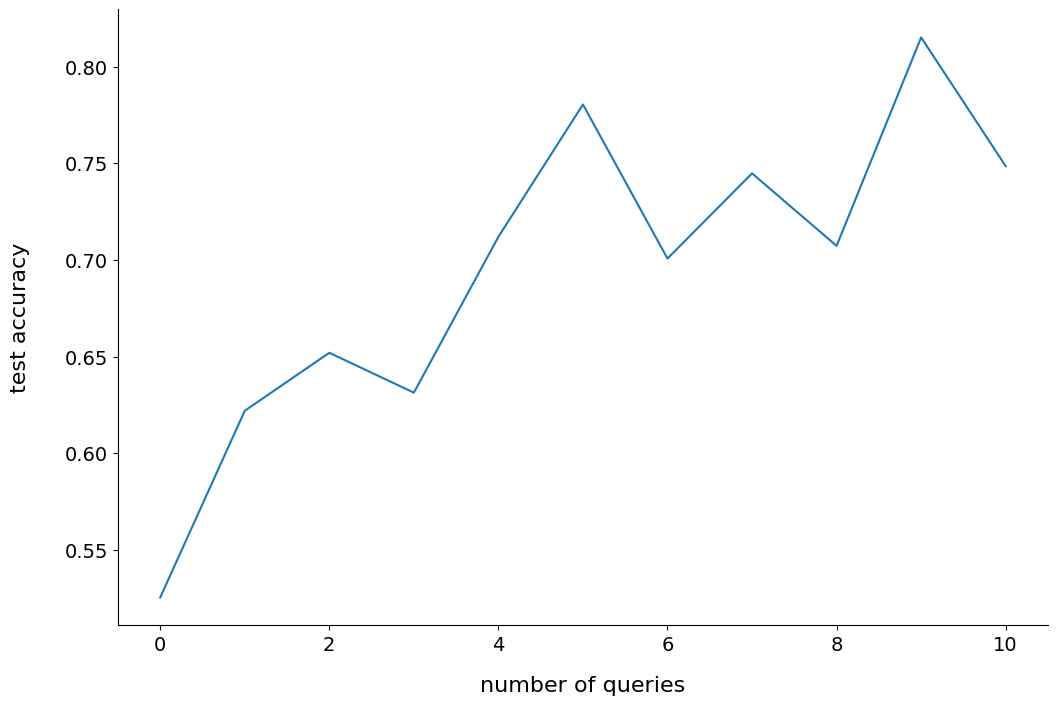

In [10]:
%matplotlib inline
%pip install "matplotlib==3.9.0"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

data = np.array([np.arange(num_queries+1), np.array(results)]).T
df = pd.DataFrame(data, columns=['query', 'accuracy'])
sns.lineplot(x='query', y='accuracy', data=df)

plt.xlabel('number of queries', labelpad=15)
plt.ylabel('test accuracy', labelpad=25)

sns.despine()